In [17]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy
import sklearn.datasets
import random

In [18]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_data = np.reshape(train_data, [-1, 28, 28, 1])

input_data = tf.placeholder("float", [None, 28, 28, 1])
resize = tf.image.resize_images(
    input_data,
    [32, 32]
)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    train_data =  sess.run(resize, feed_dict={input_data: train_data})

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [25]:
def generator(noise, message):
    input_layer = tf.contrib.layers.flatten(tf.concat([tf.cast(noise, tf.float32), tf.cast(message, tf.float32)],1))
    dense_1 = tf.layers.dense(inputs=input_layer, units=1024, name="g_dense_1")
    reshape_1 = tf.reshape(dense_1, shape=[-1, 32, 32, 1])
    
    conv_1 = tf.layers.conv2d_transpose(
      inputs=reshape_1,
      filters=64,
      kernel_size=[4, 4],
      padding="same",
      name="g_conv_1")
    
    conv_2 = tf.layers.conv2d_transpose(
      inputs=conv_1,
      filters=16,
      kernel_size=[4, 4],
      padding="same",
      name="g_conv_2")
   
    conv_3 = tf.layers.conv2d_transpose(
      inputs=conv_2,
      filters=4,
      kernel_size=[4, 4],
      padding="same",
      name="g_conv_3")

    conv_4 = tf.layers.conv2d_transpose(
      inputs=conv_3,
      filters=1,
      kernel_size=[4, 4],
      padding="same",
      name="g_conv_4",
      activation=tf.nn.tanh)
        
    return conv_4

In [26]:
def decoder(input_batch):
    pool_1 = tf.layers.average_pooling2d(inputs=input_batch, pool_size=[4, 4], strides=4)
    return tf.contrib.layers.flatten(pool_1)

In [27]:
def classifier(input_batch, reuse=False):
    conv_1 = tf.layers.conv2d(
      inputs=input_batch,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      name="d_conv_1",
      reuse=reuse)
        
    pool1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=[2, 2], strides=2)
        
    conv_2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      name="d_conv_2",
      reuse=reuse)
        
    pool2 = tf.layers.max_pooling2d(inputs=conv_2, pool_size=[2, 2], strides=2)
        
    dense_1 = tf.layers.dense(inputs=pool2, units=1024, name="d_dense_1", activation=tf.nn.relu, reuse=reuse)
    
    dropout = tf.nn.dropout(dense_1, 0.4)
    
    dense_2 = tf.layers.dense(inputs=dense_1, units=1, name="d_dense_2", reuse=reuse)

    return dense_2

In [28]:
tf.reset_default_graph()

noise = tf.placeholder("float", [None, 128])
message = tf.placeholder("float", [None, 64])
real_images = tf.placeholder("float", [None, 32, 32, 1])

BATCH_SIZE = 16
EPOCHS = 10000
gen = generator(noise, message)
dec = decoder(gen)

Dreal = classifier(real_images) #Dx will hold discriminator prediction probabilities for the real MNIST images
Dfake = classifier(gen, reuse=True) #Dg will hold discriminator prediction probabilities for generated images

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dfake, labels = tf.ones_like(Dfake)))
# message_loss = tf.losses.mean_squared_error(dec, message)  + g_loss
message_loss = g_loss

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dreal, labels = tf.ones_like(Dreal)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dfake, labels = tf.zeros_like(Dfake)))
d_loss = d_loss_real + d_loss_fake

vars = tf.trainable_variables()
gen_vars = [v for v in vars if v.name.startswith('g_')]
disc_vars = [v for v in vars if v.name.startswith('d_')]

optimizer = tf.train.AdamOptimizer()
gen_train_op = optimizer.minimize(message_loss, var_list=gen_vars)
disc_train_op = optimizer.minimize(d_loss, var_list=disc_vars)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(0, EPOCHS):
        noise_batch = np.random.uniform(-1,1,[BATCH_SIZE, 128])
        message_batch = np.random.randint(2, size=[BATCH_SIZE, 64]) / 2 + 0.25
        real_images_batch = np.array([ train_data[i] for i in sorted(random.sample(range(len(train_data)), BATCH_SIZE)) ])
        d_loss_out = 0
        d_loss_out, _1 = sess.run([d_loss, disc_train_op], feed_dict={noise: noise_batch, message: message_batch, real_images: real_images_batch})
        out, code, loss, _1 =  sess.run([gen, dec, message_loss, gen_train_op], feed_dict={noise: noise_batch, message: message_batch})
        if epoch % 100 == 0:
            print(epoch, ": g_loss: ", loss, " , desc_loss: ", d_loss_out)

ValueError: Input 0 of layer g_conv_1 is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: [None, 192]

0.0
0.25


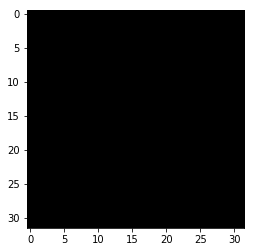

In [16]:
index1, index2 = 12, 26
print(code[index1][index2])
print(message_batch[index1][index2])
imgs = out.reshape((-1, 32, 32))
plt.imshow(imgs[index1], cmap='gray')
plt.imshow(imgs[index1], cmap='gray')
# def binary(arr):
#     out = np.copy(arr)
#     out[arr > 0.5] = 1.0
#     out[arr <= 0.5] = 0.0
#     return out
    
# def minus(one, two):
#     arr = binary(one) - binary(two)
#     arr[arr != 0] = 1
#     return sum(arr)

# for i in range(0, len(code)):
#     print(minus(message_batch[i], code[i]))
